# DAML Project 2

Importing relevant libraries and useful functions (from notes)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from iminuit import Minuit
import iminuit
import scipy

In [2]:
# Taken from the notes from many weeks ago to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')

## Part 1: Estimating statisical precision

Use the method of pseudo-experiments (toy Monte Carlo) to determine the expected statistical
precision with which one could measure each of the parameters with (i) 10,000 events and (ii)
100,000 events. Assume perfect detector-resolution/perfect time measurements.

The equation given for the relevant decay X -> D has the following PDF:
P proportional to (1 + Vsin(deltaM * t)) * exp(-t/tau) 

Can just make P = RHS and determine normalisation factor. Do this within a range of 0 to 10, rather than 1 to infinity, as the exponential component makes results beyond 10 mostly irrelevant (and the normalisation becomes a bit more difficult).

We need to build up the montecarlo simulation method to allow for precision determination in each of the parameters, tau, V and deltaM.

In [3]:
# Setting nominal values
tau = 1.5
V = 0.1
deltaM = 20.0

In [4]:
# define normalised probability density function

def decay_pdf(t, tau, V, deltaM):
    # calculated normalisation from range 0 to 10 for our probability equation
    # broke it up into parts, because otherwise it looks like a mess, and is really hard to read
    numerator = deltaM**2 * tau**2 + 1
    outer_denom = tau* np.exp(-10/tau)
    inner_denom = (deltaM**2 * tau**2 + V*deltaM*tau + 1)*np.exp(10/tau) - deltaM**2*tau**2 - V*deltaM*np.cos(10*deltaM)-V*np.sin(10*deltaM)-1
    norm = numerator/(outer_denom*inner_denom)
    # apply normalisation to pdf and return it
    pdf_val = norm*(1+V*np.sin(deltaM*t))*np.exp(-t/tau)
    return pdf_val

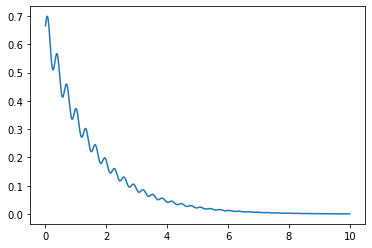

In [5]:
# Visualise the function (and to check its correct)
x_coords = np.linspace(0,10,num=1000)
y_coords = decay_pdf(x_coords, tau, V, deltaM)

plt.plot(x_coords,y_coords)
plt.show()

Plugged directly into desmos as well, looks exactly like this with the correct parameters.

Now create a box method for our PDF to create a random distribution of our function:

In [6]:
# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim(runs, tau, V, deltaM, upperlim):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list
        if (y2 < y1):
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
        



Define the nll function for our PDF, and use minuit to fit our pdf function to our box-method data. The number of events will change the statistical precision given, but the statistical uncertainty given by minuit will give us the expected statistical precision we can measure each of our parameters with.

In [7]:
def nll_decay(tau, V, deltaM):
    
    # Take data, will need to define this before calling the function, which will be done if you run through the notebook linearly
    x = np.array(pdf_list)
    
    # calculate the pdf value, already normalised
    y = decay_pdf(x, tau, V, deltaM)
    
    # limit y so that is cant be zero here
    y = [0 if y[i] < 0 else y[i] for i in range(len(y))]
    
    # take log of y
    y_log = np.log(y)
    
    # take negative sum
    nll_sum = -np.sum(y_log)
    
    return nll_sum

Generating 10,000 event PDF data

In [8]:
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(10000, tau, V, deltaM, 10)


In [9]:
# defining the plotting function used throughout the code
def plot_hist(title, pdf_list):
    # Print histogram of pdf_list and describe the results
    plt.title(title)
    plt.xlabel("Time (no unit)")
    plt.ylabel("Density")
    plt.hist(pdf_list, bins = 200, density = True)
    plt.show()
    

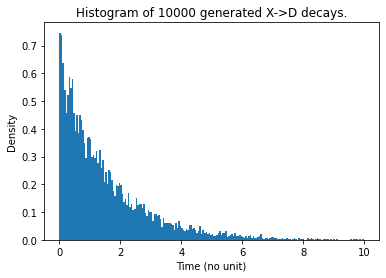

In [10]:
# and plotting our data
plot_hist("Histogram of 10000 generated X->D decays.", pdf_list)

Now to use minuit with the nll to determine the parameters from this PDF. Creating a basic minuit function that will be used throughout the code:

In [11]:
# Minuit automated function
def minuit_process(nll):

    # hardcode the errors, errordef, limits and parameter guess vals as they will be the same across the entire project
    m = Minuit(nll, tau = 1, V = 0.5, deltaM = 21)
    # Set errors
    m.errors = [1,1,2]
    # Define for NLL
    m.errordef = 0.5
    # Set limits
    m.limits = [[0,3], [0,2], [10,30]]
    
    # Fit and return fit
    result = m.migrad()
    
    return result



In [12]:
# Apply minuit and show results
m = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), m)

	 tau             :  	   1.5094  +/-    0.0156
	 V               :  	   0.1020  +/-    0.0142
	 deltaM          :  	  19.9396  +/-    0.1438




And giving the statistical precision for our main parameters:

In [13]:
# Reformatting this
# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 10000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(m.values["tau"],m.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(m.values["V"],m.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(m.values["deltaM"],m.errors["deltaM"]))



Statistical Errors for 10000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.509(0.016)
Matter/A-Matter asymm parameter (V) : 0.102(0.014)
Mass difference parameter (deltaM) : 19.94(0.14)


This shows the statistical precision of our 10000 event run for our three parameters (the brackets are the statistical precision).

Our true fit values are quite close to the true values as well, within 2 sigma (on this run at least).

Now to do the same for 100000 events, we dont need to consider the pdf_list as it is always updated before the fit is run

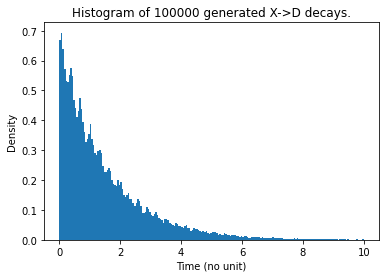

In [14]:
# 100,000 events
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(100000, tau, V, deltaM, 10)


# plot histogram
plot_hist("Histogram of 100000 generated X->D decays.", pdf_list)


In [15]:
# Apply minuit and show results
n = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), n)

	 tau             :  	   1.4965  +/-    0.0049
	 V               :  	   0.0945  +/-    0.0045
	 deltaM          :  	  19.9723  +/-    0.0230




And giving the statistical precision for our main parameters:

In [16]:
# Reformatting this

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(n.values["tau"],n.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(n.values["V"],n.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(n.values["deltaM"],n.errors["deltaM"]))


Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.496(0.0049)
Matter/A-Matter asymm parameter (V) : 0.0945(0.0045)
Mass difference parameter (deltaM) : 19.97(0.023)


So comparing the 10,000 and 100,000 statistical precision:

In [17]:
print("Statistical precision for 10,000 and 100,000")
print("Tau (10,000): {:.2}       Tau (100,000): {:.2}".format(m.errors["tau"],n.errors["tau"]))
print("V (10,000): {:.2}         V (100,000): {:.2}".format(m.errors["V"],n.errors["V"]))
print("deltaM (10,000): {:.2}    deltaM (100,000): {:.2}".format(m.errors["deltaM"],n.errors["deltaM"]))

Statistical precision for 10,000 and 100,000
Tau (10,000): 0.016       Tau (100,000): 0.0049
V (10,000): 0.014         V (100,000): 0.0045
deltaM (10,000): 0.14    deltaM (100,000): 0.023


So we can see here (understandably) that the more events we include, the better the statistical precision (the smaller the uncertainty given by the statistical error inherent in our data distribution).

Understandably, this statistical precision is able to change due to the random nature of our data production method. A way to solve this would be to run the 10,000 events multiple times to determine a bias and average for our parameters.

In [18]:
# Create a function that will automaticall do what has been done above many times to produce an average statistical precision (and error on said average)
def precision_parameter_average(iterations, events):
    # create precision and value list
    tau_av = []
    V_av = []
    deltaM_av = []
    tau_prec_av = []
    V_prec_av = []
    deltaM_prec_av = []
    
    # For number of loops
    for i in range(iterations):
        # produce data then fit it and append it
        
        # tau, V and deltaM are given outside of the function
        pdf_list = box_sim(events, tau, V, deltaM, 10)
        minui = minuit_process(nll_decay)
        
        errs = minui.errors
        vals = minui.values
        
        # data
        tau_av.append(vals["tau"])
        V_av.append(vals["V"])
        deltaM_av.append(vals["deltaM"])
        
        # errors
        tau_prec_av.append(errs["tau"])
        V_prec_av.append(errs["V"])
        deltaM_prec_av.append(errs["deltaM"])
        
        # destroy the minuit object after use, as I fear it may be causing issues
        del minui
    
    # Average data and errors
    tau_average = np.mean(tau_av)
    V_average = np.mean(V_av)
    deltaM_average = np.mean(deltaM_av)
    
    
    tau_prec_average = np.mean(tau_prec_av)
    V_prec_average = np.mean(V_prec_av)
    deltaM_prec_average = np.mean(deltaM_prec_av)
    
    # print results and return
    
    # {:.2} is significant digits (rounded to two)
    print("Statistical Errors for " + str(events) + " events with " + str(iterations) + " iterations.")
    print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
    print("Lifetime parameter (Tau) : {:.4}({:.2})".format(tau_average,tau_prec_average))
    print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(V_average,V_prec_average))
    print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(deltaM_average,deltaM_prec_average))
    
    return


    
    
    

# WARNING, IF YOU RUN THE FUNCTION BELOW, BE PREPARED FOR INCREDIBLY LONG RUNTIMES. 

On my home computer, the 10000 events process 10 times took a minute or so, the 100,000 events will take even longer (on i7-9700K CPU, so this is no small feat). So you've been warned.

This section also doesn't appear to work as intented, as is discussed at the end of the section.

In [25]:
# Run the behemoth of a function. 10 times for 10000 events

#UNCOMMENT HERE
#precision_parameter_average(10, 10000)

Statistical Errors for 10000 events with 10 iterations.
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.501(0.0049)
Matter/A-Matter asymm parameter (V) : 0.0991(0.0045)
Mass difference parameter (deltaM) : 19.99(0.021)


Similar results to 1 100,000 event run which is to be expected because its 10 10,000 runs...oops!
At least I can test to see if we can make the result even smaller in this next part, and then reuse this code for part 2!

In [24]:
# Run the behemoth of a function. 10 times for 100000 events

#UNCOMMENT HERE
#precision_parameter_average(10, 100000)

Statistical Errors for 100000 events with 10 iterations.
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.498(0.0049)
Matter/A-Matter asymm parameter (V) : 0.1037(0.0045)
Mass difference parameter (deltaM) : 20.0(0.021)


After quite a lot of investigation, this section seemed to be a bust, and I wasnt sure why. The function didn't work as intended and always gave out the same uncertainty values (to the maximum significant figures possible with python/minuit). I believed it was something to do with the minuit object, as it was always giving the same values as the previous minuit fit, but I couldn't figure it out. Regardless, this section is conclusive about the advantage of more events without it.

I use a similar function in part 2, and found the error to be something to do with producing the new pdf_list values within the function. The minuit fitting function would only recognise them as existing if you produced them within the function, but then used the previous pdf_list values from outside the function. I couldn't figure out why this was, even after a lot of testing (moving pdf_list about, out of the function, calling it something different and then manually changing the name to pdf_list in the function, etc), so instead in the next section I opted to do all the work in a loop outwith a function, which worked as expected.

## Part 2: Estimating possible bias due to time resolution

Decay time is measured with random error and standard deviation of $\sigma = f\times \tau$ where f is some fraction.

If true decay time is $t_{true}$, then it is actually measured as t where t is distributed around $t_{true}$ with Gaussian probability distribution and standard deviation $\sigma$

So first task is determining the bias introduced to the measurement of each of the parameters when the data is subject to the resolution effect, but this is not included in the PDF used for fitting the parameters.

So rewrite the box method including this gaussian time dependence:

In [19]:
# gets a value around a certain mu within the gaussian distribution
def gaussian(mu, sig):
    value = np.random.normal(mu, sig, 1)
    return value[0]
    

# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim_gauss(runs, tau, V, deltaM, upperlim, fraction):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list. Include time acceptance resolution stuff here
        if (y2 < y1):
            
            # find sigma
            sigma = fraction * tau
            # find point around x1 (the mu) within sigma
            x1 = gaussian(x1, sigma)
            
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
        


Generating new data for our f = 0.01 values

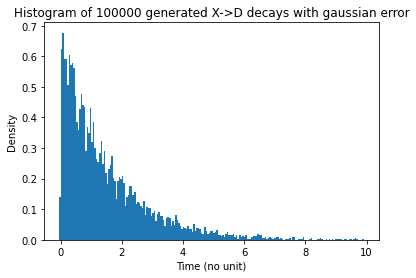

In [20]:
# Generate new data with our box_sim_gauss function, f = 0.01
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, 0.01)

# plot histogram
plot_hist("Histogram of 100000 generated X->D decays with gaussian error", pdf_list)


Fit using our previous NLL function and minuit onto this new data.

In [21]:
# Apply minuit and show results
o = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), o)


	 tau             :  	   1.4903  +/-    0.0153
	 V               :  	   0.1135  +/-    0.0143
	 deltaM          :  	  19.9986  +/-    0.0710




Printing results, then comparing with previous results from part 1 (10k events) to get the bias.

In [22]:

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(o.values["tau"],o.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(o.values["V"],o.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(o.values["deltaM"],o.errors["deltaM"]))
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit values from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(o.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(o.values["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(o.values["deltaM"]-m.values["deltaM"])))

Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.49(0.015)
Matter/A-Matter asymm parameter (V) : 0.1135(0.014)
Mass difference parameter (deltaM) : 20.0(0.071)

Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.01906
Matter/A-Matter asymm parameter (V) : 0.01147
Mass difference parameter (deltaM) : 0.05892


So we can see here the bias produced due to the introduction of the gaussian error into our data production, but not our fitting. The bias produced here is within a few factors (in some cases less than one) of our statistical error for this fit and those in part 1, which demonstrates the significant effect it has on our data and fitting capabilities.

No onto f = 0.03, generating the new data:

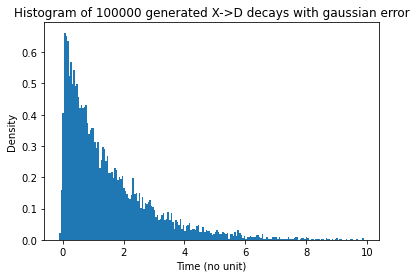

In [23]:
# Generate new data with our box_sim_gauss function, f = 0.03
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, 0.03)

# plot histogram
plot_hist("Histogram of 100000 generated X->D decays with gaussian error", pdf_list)



In [24]:
# Apply minuit and show results
p = minuit_process(nll_decay)
showIminuitResult(("tau","V","deltaM"), p)


	 tau             :  	   1.5115  +/-    0.0156
	 V               :  	   0.0226  +/-    0.0142
	 deltaM          :  	  19.0382  +/-    0.1939




In [25]:

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(p.values["tau"],p.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(p.values["V"],p.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(p.values["deltaM"],p.errors["deltaM"]))
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit errors from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(p.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(p.errors["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(p.values["deltaM"]-m.values["deltaM"])))

Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.512(0.016)
Matter/A-Matter asymm parameter (V) : 0.02262(0.014)
Mass difference parameter (deltaM) : 19.04(0.19)

Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.002116
Matter/A-Matter asymm parameter (V) : 0.08781
Mass difference parameter (deltaM) : 0.9014


The lifetime parameter bias here (in this run) is quite small when compared to the statistical error. This is not the case for our M/AM and mass difference parameters. This is because the exponential component that defines the lifetime is mostly unchanged by these small gaussian errors (in theory), but what about our other parameters?

Looking at the graph above, it is clear why this is the case. The V and $\Delta M$ parameters are defined by the sinusoidal components in the original function, and the gaussian noise almost wipes them out entirely, making it very difficult for our fitting process to determine their values with great accuracy.

So in this case here, we can see that the bias produced by the gaussian error is significant when compared to the statistical precisions of the fit, and are even larger in the cases of the M/AM and mass difference parameters for a fraction of f = 0.03.


And then lets compare biases from the 0.01 and 0.03 fractions:

In [29]:
print("FRACTION 0.01 BIAS RESULTS W/ ERRORS")
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(o.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(o.values["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(o.values["deltaM"]-m.values["deltaM"])))
print("")
print("Statistical Errors")
print("Lifetime parameter (Tau) : ({:.2})".format(o.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : ({:.2})".format(o.errors["V"]))
print("Mass difference parameter (deltaM) : ({:.2})".format(o.errors["deltaM"]))
print("")
print("")
print("FRACTION 0.03 BIAS RESULTS")
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(p.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(p.errors["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(p.values["deltaM"]-m.values["deltaM"])))
print("")
print("Statistical Errors")
print("Lifetime parameter (Tau) : ({:.2})".format(p.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : ({:.2})".format(p.errors["V"]))
print("Mass difference parameter (deltaM) : ({:.2})".format(p.errors["deltaM"]))

FRACTION 0.01 BIAS RESULTS W/ ERRORS
Lifetime parameter bias (Tau) : 0.01906
Matter/A-Matter asymm parameter (V) : 0.01147
Mass difference parameter (deltaM) : 0.05892

Statistical Errors
Lifetime parameter (Tau) : (0.015)
Matter/A-Matter asymm parameter (V) : (0.014)
Mass difference parameter (deltaM) : (0.071)


FRACTION 0.03 BIAS RESULTS
Lifetime parameter bias (Tau) : 0.002116
Matter/A-Matter asymm parameter (V) : 0.08781
Mass difference parameter (deltaM) : 0.9014

Statistical Errors
Lifetime parameter (Tau) : (0.016)
Matter/A-Matter asymm parameter (V) : (0.014)
Mass difference parameter (deltaM) : (0.19)


So as we can see here, as we increase the fraction of gaussian noise in our data, the bias increases for our M/AM and mass difference parameters. This is understandable considering the importance of the sinusoidal component of the PDF to their fitting.

But the data we generate is random by nature, so these biases will change on a run-by-run basis. As you can see with our Tau value in the fraction 0.03 being really similar to the part 1 run (bias of 0.002 in this case). So if we do many simulations of this same process and obtain the biases, we can determine an 'average bias' and a consequent error on the bias. This will be useful for solidifying our results further.

So, to make the process automatic, need to create little functional loops that will create new data, fit it and output the biases as we need them:

In [30]:
def collate_bias_components(pdf_list):
    mini = minuit_process(nll_decay)
    print(mini)

    errs = mini.errors
    vals = mini.values

    # data
    tau_list.append(vals["tau"])
    V_list.append(vals["V"])
    deltaM_list.append(vals["deltaM"])

    # errors
    tau_prec_list.append(errs["tau"])
    V_prec_list.append(errs["V"])
    deltaM_prec_list.append(errs["deltaM"])
    
    return tau_list, V_list, deltaM_list, tau_prec_list, V_prec_list, deltaM_prec_list

In [31]:
# Method for calculating bias average and its  
def bias_average(fraction, iterations):
    # create list for each parameter
    tau_list = []
    V_list = []
    deltaM_list = []
    tau_prec_list = []
    V_prec_list = []
    deltaM_prec_list =[]
    
    # create loop, 10000 events per each simulation
    for i in range(iterations):
        del pdf_list
        pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, fraction)
        tau_list, V_list, deltaM_list, tau_prec_list, V_prec_list, deltaM_prec_list = collate_bias_components(pdf_list)    
    
    # Calculate the standard averages for these parameters and their errors
    tau_average = np.mean(tau_list)
    V_average = np.mean(V_list)
    deltaM_average = np.mean(deltaM_list)
    
    # standard averages of the statistical uncertainty (from minuit). Unsure whether to use this or not yet, but being calculated.
    tau_prec_average = np.mean(tau_prec_list)
    V_prec_average = np.mean(V_prec_list)
    deltaM_prec_average = np.mean(deltaM_prec_list)  
    
    # take standard error on these values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_list))
    tau_std = np.std(tau_list)/events_sqrt
    V_std = np.std(V_list)/events_sqrt
    deltaM_std = np.std(deltaM_list)/events_sqrt
    
    # calculate biases against average values from part 1 10,000 event run
    tau_bias = abs(tau_average - m.values["tau"])
    V_bias = abs(V_average - m.values["V"])
    deltaM_bias = abs(deltaM_average - m.values["deltaM"])
    
    # returning ALL the values, so that we can determine which ones are useful.
    return tau_average, V_average, deltaM_average, tau_bias, V_bias, deltaM_bias, tau_std,  V_std, deltaM_std, tau_prec_average, V_prec_average, deltaM_prec_average
    

    

In [32]:
def print_bias_results(bias_results):
    print("Tau value: {:.4}   Tau Bias: {:.4}\nTau standard error: {:.4}    Tau average minuit error: {:.4}\n".format(bias_results[0],bias_results[3],bias_results[6],bias_results[9]))
    print("V value: {:.4}   V Bias: {:.4}\nV standard error: {:.4}    V average minuit error: {:.4}\n".format(bias_results[1],bias_results[4],bias_results[7],bias_results[10]))
    print("deltaM value: {:.4}   deltaM Bias: {:.4}\ndeltaM standard error: {:.4}    deltaM average minuit error: {:.4}".format(bias_results[2],bias_results[5],bias_results[8],bias_results[11]))

### The function above didnt work, it appears to be because it decides to pull the pdf_list from a previous list rather than the one produced one line before, BUT if you try and remove this pdf_list from within the function it doesnt recognise it as existing.

This was clearly the same issue that I was experiencing in part 1. The sad and simple solution is that I need to pull the process out of the function, then it works perfectly. Be careful when running this next section of code as it will take a while.

Running 100 simulations for each of the 10k events, for each of the fractions and pulling out the bias and other relevant statistical information

In [34]:
fractions = [0.01, 0.03]
simulation_runs = []
sim_titles = ["Fraction 0.01 Results:\n", "Fraction 0.03 Results:\n"]


for j in range(2):
    # create list for each parameter
    tau_list = []
    V_list = []
    deltaM_list = []
    tau_prec_list = []
    V_prec_list = []
    deltaM_prec_list =[]

    # create loop, 10000 events per each simulation, 100 sims for each
    for i in range(100):

        # generate the data
        pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, fractions[j])
        # create minuit object and fit to data, then collect it for each loop
        mini = minuit_process(nll_decay)

        errs = mini.errors
        vals = mini.values

        # data
        tau_list.append(vals["tau"])
        V_list.append(vals["V"])
        deltaM_list.append(vals["deltaM"])

        # errors
        tau_prec_list.append(errs["tau"])
        V_prec_list.append(errs["V"])
        deltaM_prec_list.append(errs["deltaM"])


    # Calculate the standard averages for these parameters and their errors
    tau_average = np.mean(tau_list)
    V_average = np.mean(V_list)
    deltaM_average = np.mean(deltaM_list)

    # standard averages of the statistical uncertainty (from minuit). Unsure whether to use this or not yet, but being calculated.
    tau_prec_average = np.mean(tau_prec_list)
    V_prec_average = np.mean(V_prec_list)
    deltaM_prec_average = np.mean(deltaM_prec_list)  

    # take standard error on these values, which will be used as standard error on our bias
    events_sqrt = np.sqrt(len(tau_list))
    tau_std = np.std(tau_list)/events_sqrt
    V_std = np.std(V_list)/events_sqrt
    deltaM_std = np.std(deltaM_list)/events_sqrt

    # calculate biases against average values from part 1 10,000 event run
    tau_bias = abs(tau_average - m.values["tau"])
    V_bias = abs(V_average - m.values["V"])
    deltaM_bias = abs(deltaM_average - m.values["deltaM"])
    
    
    # save and print the data
    data = tau_average, V_average, deltaM_average, tau_bias, V_bias, deltaM_bias, tau_std,  V_std, deltaM_std, tau_prec_average, V_prec_average, deltaM_prec_average

    simulation_runs.append([data])
    
    print(sim_titles[j])
    print_bias_results(data)
    print("==========================")


Fraction 0.01 Results:

Tau value: 1.499   Tau Bias: 0.009987
Tau standard error: 0.001486    Tau average minuit error: 0.01533

V value: 0.08642   V Bias: 0.01563
V standard error: 0.002564    V average minuit error: 0.01782

deltaM value: 19.97   deltaM Bias: 0.02818
deltaM standard error: 0.1197    V average minuit error: 0.2016


C:\Users\John\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Fraction 0.03 Results:

Tau value: 1.496   Tau Bias: 0.01315
Tau standard error: 0.001377    Tau average minuit error: 0.01418

V value: 0.0373   V Bias: 0.06475
V standard error: 0.002305    V average minuit error: 0.05805

deltaM value: 20.23   deltaM Bias: 0.2922
deltaM standard error: 0.1365    V average minuit error: 2.014


Bias increases between the 0.01 -> 0.03 values, but the difference is a lot more significant for the V and $\Delta M$ bias, as these are more affected by the loss of information around the sinusoidal components of the PDFs.

Considering these biases with the minuit error shows for the tau values that the bias is significant in relation to the statistical error, and so would have to be considered when determining a total error.

For our V bias, minuit's statistical error is slightly larger than our bias for f(0.01) and smaller for f(0.03) across the averages. This demonstrates that the larger the noise, the more significant the bias is on our results and the harder minuit finds to fit it accurately (minuit error goes up by a factor of 5 between the runs).

For our $\Delta M$ value, the f(0.03) bias is larger by a factor of 10, which is still quite small considering that the true value of $\Delta M$ is 20 and we achieve 19.97 and 20.23 respectively. This still demonstrates that with more noise, our fitting model has more difficulty accurately matching the data and 

(found by taking the standard deviation of the averages, and dividing by the number of events) shows that the fitting is 

## Part 3: Estimating a systematic error due to time acceptance

Measuring decay-time is thought to exhibit a decay-time acceptance of $a(t) = (1+st)$ with precision of $s = 0 \pm 0.03$.

Determine a suitable systematic error to assign to the measurement of each of the parameters due to this limited knowledge of a(t) and in each case compare this systematic error to the expected statistical precision